In [1]:
import os
import cv2
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
import os
from zipfile import ZipFile

# downloading the dataset
!pip install kaggle


os.environ['KAGGLE_USERNAME'] = "majisouvik1099"
os.environ['KAGGLE_KEY'] = "9464225218d56f8bfea9dd9cc437489f"


!kaggle datasets download -d jessicali9530/lfw-dataset


with ZipFile('lfw-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('lfw-dataset')


os.remove('lfw-dataset.zip')


lfw-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:

def extract_features(image_path, model):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    features = features.squeeze(0)
    return features


def compute_hog(img):
    resized_img = resize(img, (128*4, 64*4))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    return fd


def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))
    val_ar.append(get_pixel(img, center, x, y+1))
    val_ar.append(get_pixel(img, center, x+1, y+1))
    val_ar.append(get_pixel(img, center, x+1, y))
    val_ar.append(get_pixel(img, center, x+1, y-1))
    val_ar.append(get_pixel(img, center, x, y-1))
    val_ar.append(get_pixel(img, center, x-1, y-1))
    val_ar.append(get_pixel(img, center, x-1, y))

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val

def calcLBP(img):
    height, width, channel = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    return hist_lbp.flatten()


In [4]:
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.5MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [24]:
lfw_folder = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
X, y = [], []
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                hog_feature = compute_hog(image)
                lbp_feature = calcLBP(image)
                # cnn_feature = extract_features(image_path, resnet).numpy()
                hog_feature = hog_feature.reshape(-1)
                lbp_feature = lbp_feature.reshape(-1)
                # cnn_feature = cnn_feature.flatten()
                combined_feature = np.concatenate((hog_feature, lbp_feature))

                X.append(combined_feature)
                y.append(folder_name)


<ipython-input-3-8d0f7df1f55f>:19: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),


In [25]:
np.array(X).shape

(1288, 70564)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [27]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [28]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(MLPClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers


        self.input_layer = nn.Linear(input_size, hidden_size)


        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))


        self.output_layer = nn.Linear(hidden_size, output_size)


        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x


input_size = 70564
hidden_size = 512
output_size = len(np.unique(y_train_encoded))
num_hidden_layers = 2
model = MLPClassifier(input_size, hidden_size, output_size, num_hidden_layers)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


num_epochs = 500
best_accuracy = 0.0
lowest_overfitting = float('inf')
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        loss = criterion(outputs, y_test_tensor)
        test_losses.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y_test_tensor).sum().item()
        total = y_test_tensor.size(0)
        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)

        _, predicted_train = torch.max(model(X_train_tensor), 1)
        correct_train = (predicted_train == y_train_tensor).sum().item()
        total_train = y_train_tensor.size(0)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        if loss.item() < lowest_overfitting:
            lowest_overfitting = loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')


best_model = MLPClassifier(input_size, hidden_size, output_size, num_hidden_layers)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model = best_model.to(device)


print('Best Model:')
print(best_model)

print(f'Lowest Overfitting Loss: {lowest_overfitting}')


best_model.eval()
with torch.no_grad():
    outputs = best_model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    print('Classification Report:')
    print(classification_report(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))




Epoch 1/500, Train Loss: 1.9147281646728516, Test Loss: 1.7607529163360596, Train Accuracy: 0.42524271844660194, Test Accuracy: 0.37209302325581395
Epoch 2/500, Train Loss: 1.7311735153198242, Test Loss: 1.7194035053253174, Train Accuracy: 0.4223300970873786, Test Accuracy: 0.3682170542635659
Epoch 3/500, Train Loss: 1.6537413597106934, Test Loss: 1.7180925607681274, Train Accuracy: 0.4223300970873786, Test Accuracy: 0.3682170542635659
Epoch 4/500, Train Loss: 1.6375175714492798, Test Loss: 1.7261855602264404, Train Accuracy: 0.4223300970873786, Test Accuracy: 0.3682170542635659
Epoch 5/500, Train Loss: 1.634695053100586, Test Loss: 1.7181733846664429, Train Accuracy: 0.4223300970873786, Test Accuracy: 0.3682170542635659
Epoch 6/500, Train Loss: 1.6277527809143066, Test Loss: 1.7016232013702393, Train Accuracy: 0.4223300970873786, Test Accuracy: 0.3682170542635659
Epoch 7/500, Train Loss: 1.61854887008667, Test Loss: 1.6886351108551025, Train Accuracy: 0.42718446601941745, Test Accurac

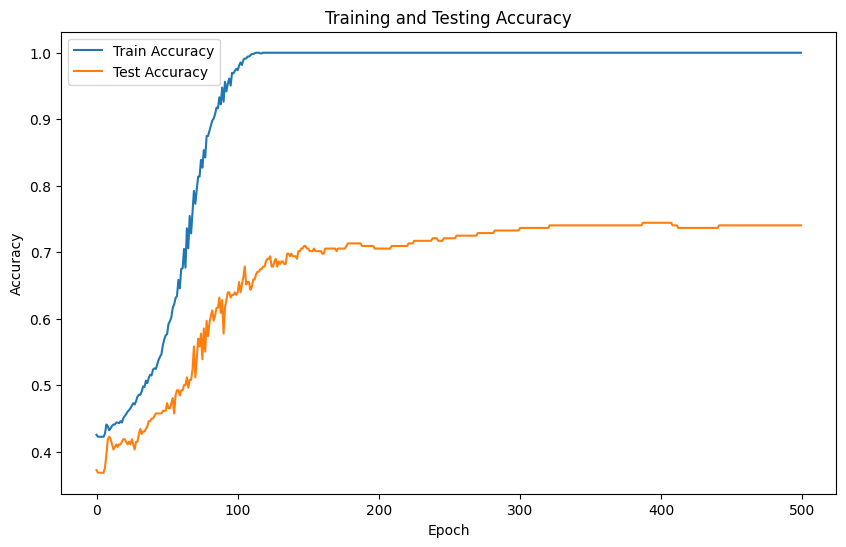

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()